# Generative Adversarial Networks in PyTorch

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

To get a sense of the power of generative models, just visit [thispersondoesnotexist.com](https://thispersondoesnotexist.com). Every time you reload the page, a new image of a person's face is generated on the fly. The results are pretty fascinating:

<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" style="width:480px; margin-bottom:32px"/>

While there are many approaches used for generative modeling, a Generative Adversarial Network takes the following approach: 

<img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px"/>

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. 

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. In this tutorial, we'll train a GAN to generate images of human faces.



We'll use the [utk-face-cropped dataset](https://kaggle.com/abhikjha/utk-face-cropped?utm_medium=social&utm_campaign=kaggle-dataset-share&utm_source=twitter), which consists of over 63,000 cropped anime faces. Note that generative modeling is an unsupervised learning task, so the images do not have any labels. Most of the code in this tutorial is based on this notebook: https://www.kaggle.com/splcher/starter-anime-face-dataset

In [5]:
project_name = 'human-faces-byGANS'

In [8]:
# Uncomment and install libraries if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

## Loading the Data

If you're running this notebook on Kaggle, you can use the "+ Add data" option from the sidebar and search for [Anime Face Dataset](https://www.kaggle.com/splcher/animefacedataset). This will download the data to `../input`. 

If you're the notebook elsewhere, download the data from this Google Drive link, and change the `DATA_DIR` variable below to point to the relative path of the dataset.

In [9]:
DATA_DIR = '../input/utk-face-cropped/'

The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [10]:
import os

print(os.listdir(DATA_DIR))

['utkcropped']


In [11]:
print(os.listdir(DATA_DIR+'/utkcropped')[:10])

['29_1_0_20170117130557275.jpg.chip.jpg', '26_0_3_20170104230509745.jpg.chip.jpg', '26_1_3_20170119180502866.jpg.chip.jpg', '58_0_0_20170117172932280.jpg.chip.jpg', '15_0_3_20170104225254497.jpg.chip.jpg', '85_1_0_20170110184106700.jpg.chip.jpg', '32_0_4_20170104005921031.jpg.chip.jpg', '40_0_3_20170119210206582.jpg.chip.jpg', '23_1_3_20170119164419982.jpg.chip.jpg', '1_0_0_20170110213517302.jpg.chip.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [12]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [13]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [14]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [15]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [17]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

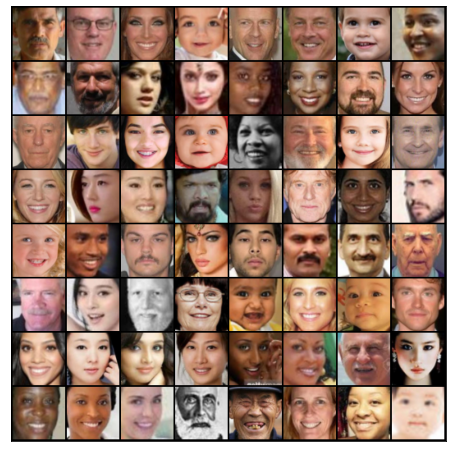

In [18]:
show_batch(train_dl)

In [2]:
!pip install jovian --upgrade --quiet

In [20]:
import jovian

<IPython.core.display.Javascript object>

In [21]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/satyamkumar073/06b-anime-dcgan


<IPython.core.display.Javascript object>

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [23]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [24]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [25]:
import torch.nn as nn

In [26]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [27]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [28]:
latent_size = 128

In [29]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


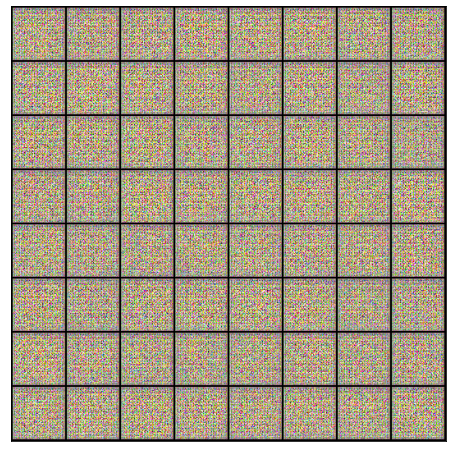

In [30]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [31]:
generator = to_device(generator, device)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [32]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [33]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [34]:
from torchvision.utils import save_image

In [35]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [36]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [37]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


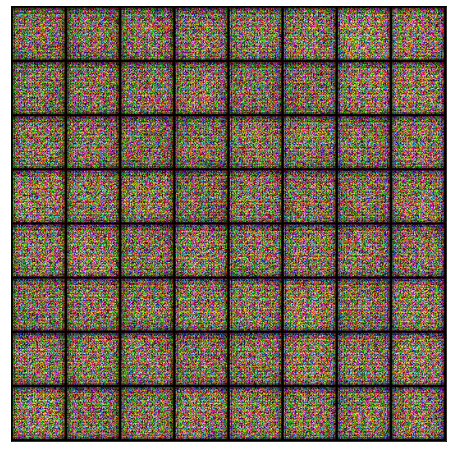

In [38]:
save_samples(0, fixed_latent)

In [39]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/satyamkumar073/06b-anime-dcgan


<IPython.core.display.Javascript object>

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [40]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [41]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [42]:
lr = 0.0001
epochs = 100

In [43]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [44]:
history = fit(epochs, lr)


Epoch [1/100], loss_g: 7.1092, loss_d: 0.0604, real_score: 0.9774, fake_score: 0.0360
Saving generated-images-0001.png



Epoch [2/100], loss_g: 6.9813, loss_d: 0.0264, real_score: 0.9883, fake_score: 0.0108
Saving generated-images-0002.png



Epoch [3/100], loss_g: 3.9124, loss_d: 0.2956, real_score: 0.8068, fake_score: 0.0521
Saving generated-images-0003.png



Epoch [4/100], loss_g: 4.0207, loss_d: 0.0961, real_score: 0.9481, fake_score: 0.0370
Saving generated-images-0004.png



Epoch [5/100], loss_g: 4.1530, loss_d: 0.3023, real_score: 0.9616, fake_score: 0.2007
Saving generated-images-0005.png



Epoch [6/100], loss_g: 7.5490, loss_d: 0.6003, real_score: 0.9220, fake_score: 0.3295
Saving generated-images-0006.png



Epoch [7/100], loss_g: 3.4432, loss_d: 0.1643, real_score: 0.9234, fake_score: 0.0732
Saving generated-images-0007.png



Epoch [8/100], loss_g: 3.6271, loss_d: 0.0813, real_score: 0.9580, fake_score: 0.0351
Saving generated-images-0008.png



Epoch [9/100], loss_g: 5.0874, loss_d: 0.0304, real_score: 0.9755, fake_score: 0.0049
Saving generated-images-0009.png



Epoch [10/100], loss_g: 4.4989, loss_d: 0.2281, real_score: 0.9622, fake_score: 0.1513
Saving generated-images-0010.png



Epoch [11/100], loss_g: 4.7453, loss_d: 0.0339, real_score: 0.9715, fake_score: 0.0042
Saving generated-images-0011.png



Epoch [12/100], loss_g: 5.0823, loss_d: 0.0819, real_score: 0.9639, fake_score: 0.0418
Saving generated-images-0012.png



Epoch [13/100], loss_g: 3.7101, loss_d: 0.2882, real_score: 0.8151, fake_score: 0.0351
Saving generated-images-0013.png



Epoch [14/100], loss_g: 4.3335, loss_d: 0.0848, real_score: 0.9408, fake_score: 0.0187
Saving generated-images-0014.png



Epoch [15/100], loss_g: 3.7244, loss_d: 0.0849, real_score: 0.9677, fake_score: 0.0480
Saving generated-images-0015.png



Epoch [16/100], loss_g: 4.8167, loss_d: 0.0933, real_score: 0.9562, fake_score: 0.0428
Saving generated-images-0016.png



Epoch [17/100], loss_g: 6.1480, loss_d: 0.2710, real_score: 0.9482, fake_score: 0.1694
Saving generated-images-0017.png



Epoch [18/100], loss_g: 4.3695, loss_d: 0.1561, real_score: 0.9806, fake_score: 0.1117
Saving generated-images-0018.png



Epoch [19/100], loss_g: 4.1094, loss_d: 0.1900, real_score: 0.9252, fake_score: 0.0864
Saving generated-images-0019.png



Epoch [20/100], loss_g: 5.0468, loss_d: 0.0412, real_score: 0.9759, fake_score: 0.0152
Saving generated-images-0020.png



Epoch [21/100], loss_g: 6.7182, loss_d: 0.0978, real_score: 0.9811, fake_score: 0.0665
Saving generated-images-0021.png



Epoch [22/100], loss_g: 4.2260, loss_d: 0.1760, real_score: 0.9016, fake_score: 0.0478
Saving generated-images-0022.png



Epoch [23/100], loss_g: 5.8725, loss_d: 0.1277, real_score: 0.9597, fake_score: 0.0770
Saving generated-images-0023.png



Epoch [24/100], loss_g: 5.4589, loss_d: 0.1905, real_score: 0.9588, fake_score: 0.1240
Saving generated-images-0024.png



Epoch [25/100], loss_g: 4.0633, loss_d: 0.0470, real_score: 0.9684, fake_score: 0.0134
Saving generated-images-0025.png



Epoch [26/100], loss_g: 3.5657, loss_d: 0.5892, real_score: 0.6614, fake_score: 0.0006
Saving generated-images-0026.png



Epoch [27/100], loss_g: 4.3521, loss_d: 0.0924, real_score: 0.9443, fake_score: 0.0278
Saving generated-images-0027.png



Epoch [28/100], loss_g: 2.4267, loss_d: 0.1759, real_score: 0.8828, fake_score: 0.0282
Saving generated-images-0028.png



Epoch [29/100], loss_g: 7.8352, loss_d: 4.9253, real_score: 0.0677, fake_score: 0.0000
Saving generated-images-0029.png



Epoch [30/100], loss_g: 5.0030, loss_d: 0.1068, real_score: 0.9772, fake_score: 0.0739
Saving generated-images-0030.png



Epoch [31/100], loss_g: 4.4611, loss_d: 0.0654, real_score: 0.9636, fake_score: 0.0246
Saving generated-images-0031.png



Epoch [32/100], loss_g: 5.5463, loss_d: 0.2328, real_score: 0.9904, fake_score: 0.1665
Saving generated-images-0032.png



Epoch [33/100], loss_g: 6.8497, loss_d: 0.0509, real_score: 0.9621, fake_score: 0.0055
Saving generated-images-0033.png



Epoch [34/100], loss_g: 6.6946, loss_d: 0.2578, real_score: 0.8208, fake_score: 0.0016
Saving generated-images-0034.png



Epoch [35/100], loss_g: 4.1968, loss_d: 0.0373, real_score: 0.9783, fake_score: 0.0140
Saving generated-images-0035.png



Epoch [36/100], loss_g: 4.8882, loss_d: 0.0654, real_score: 0.9705, fake_score: 0.0328
Saving generated-images-0036.png



Epoch [37/100], loss_g: 5.2151, loss_d: 0.0730, real_score: 0.9728, fake_score: 0.0416
Saving generated-images-0037.png



Epoch [38/100], loss_g: 5.3126, loss_d: 0.1135, real_score: 0.9262, fake_score: 0.0127
Saving generated-images-0038.png



Epoch [39/100], loss_g: 5.2369, loss_d: 0.0642, real_score: 0.9711, fake_score: 0.0275
Saving generated-images-0039.png



Epoch [40/100], loss_g: 5.6763, loss_d: 0.0681, real_score: 0.9925, fake_score: 0.0547
Saving generated-images-0040.png



Epoch [41/100], loss_g: 4.8397, loss_d: 0.0491, real_score: 0.9668, fake_score: 0.0111
Saving generated-images-0041.png



Epoch [42/100], loss_g: 5.8566, loss_d: 0.0621, real_score: 0.9855, fake_score: 0.0439
Saving generated-images-0042.png



Epoch [43/100], loss_g: 12.0498, loss_d: 2.2157, real_score: 0.9994, fake_score: 0.6654
Saving generated-images-0043.png



Epoch [44/100], loss_g: 3.5667, loss_d: 0.1459, real_score: 0.8921, fake_score: 0.0081
Saving generated-images-0044.png



Epoch [45/100], loss_g: 3.3325, loss_d: 0.1750, real_score: 0.8727, fake_score: 0.0073
Saving generated-images-0045.png



Epoch [46/100], loss_g: 3.0963, loss_d: 0.1593, real_score: 0.8850, fake_score: 0.0128
Saving generated-images-0046.png



Epoch [47/100], loss_g: 6.1870, loss_d: 0.0941, real_score: 0.9803, fake_score: 0.0669
Saving generated-images-0047.png



Epoch [48/100], loss_g: 5.9327, loss_d: 0.1213, real_score: 0.9589, fake_score: 0.0657
Saving generated-images-0048.png



Epoch [49/100], loss_g: 3.6952, loss_d: 0.1198, real_score: 0.9135, fake_score: 0.0135
Saving generated-images-0049.png



Epoch [50/100], loss_g: 5.4054, loss_d: 0.0334, real_score: 0.9872, fake_score: 0.0196
Saving generated-images-0050.png



Epoch [51/100], loss_g: 3.3751, loss_d: 0.1297, real_score: 0.9621, fake_score: 0.0745
Saving generated-images-0051.png



Epoch [52/100], loss_g: 5.5185, loss_d: 0.0541, real_score: 0.9815, fake_score: 0.0326
Saving generated-images-0052.png



Epoch [53/100], loss_g: 3.3893, loss_d: 0.2958, real_score: 0.8651, fake_score: 0.0965
Saving generated-images-0053.png



Epoch [54/100], loss_g: 4.5912, loss_d: 0.1002, real_score: 0.9634, fake_score: 0.0549
Saving generated-images-0054.png



Epoch [55/100], loss_g: 6.8155, loss_d: 0.0297, real_score: 0.9895, fake_score: 0.0185
Saving generated-images-0055.png



Epoch [56/100], loss_g: 8.8994, loss_d: 0.5147, real_score: 0.9940, fake_score: 0.3062
Saving generated-images-0056.png



Epoch [57/100], loss_g: 5.0426, loss_d: 0.0338, real_score: 0.9859, fake_score: 0.0188
Saving generated-images-0057.png



Epoch [58/100], loss_g: 4.9684, loss_d: 0.0890, real_score: 0.9464, fake_score: 0.0280
Saving generated-images-0058.png



Epoch [59/100], loss_g: 3.2423, loss_d: 0.1251, real_score: 0.9113, fake_score: 0.0208
Saving generated-images-0059.png



Epoch [60/100], loss_g: 4.0024, loss_d: 0.1242, real_score: 0.9250, fake_score: 0.0362
Saving generated-images-0060.png



Epoch [61/100], loss_g: 3.5639, loss_d: 0.1347, real_score: 0.9108, fake_score: 0.0302
Saving generated-images-0061.png



Epoch [62/100], loss_g: 5.0835, loss_d: 0.0598, real_score: 0.9632, fake_score: 0.0193
Saving generated-images-0062.png



Epoch [63/100], loss_g: 4.5467, loss_d: 0.0681, real_score: 0.9967, fake_score: 0.0576
Saving generated-images-0063.png



Epoch [64/100], loss_g: 5.2643, loss_d: 0.1171, real_score: 0.9686, fake_score: 0.0638
Saving generated-images-0064.png



Epoch [65/100], loss_g: 3.4625, loss_d: 0.1636, real_score: 0.9004, fake_score: 0.0386
Saving generated-images-0065.png



Epoch [66/100], loss_g: 3.8817, loss_d: 0.1770, real_score: 0.9019, fake_score: 0.0326
Saving generated-images-0066.png



Epoch [67/100], loss_g: 7.5699, loss_d: 0.0149, real_score: 0.9974, fake_score: 0.0120
Saving generated-images-0067.png



Epoch [68/100], loss_g: 3.8368, loss_d: 0.2210, real_score: 0.9449, fake_score: 0.1207
Saving generated-images-0068.png



Epoch [69/100], loss_g: 6.2811, loss_d: 0.0351, real_score: 0.9936, fake_score: 0.0274
Saving generated-images-0069.png



Epoch [70/100], loss_g: 4.6196, loss_d: 0.0886, real_score: 0.9450, fake_score: 0.0259
Saving generated-images-0070.png



Epoch [71/100], loss_g: 4.2833, loss_d: 0.1260, real_score: 0.9374, fake_score: 0.0516
Saving generated-images-0071.png



Epoch [72/100], loss_g: 3.9011, loss_d: 0.0887, real_score: 0.9458, fake_score: 0.0252
Saving generated-images-0072.png



Epoch [73/100], loss_g: 5.3215, loss_d: 0.0643, real_score: 0.9462, fake_score: 0.0064
Saving generated-images-0073.png



Epoch [74/100], loss_g: 5.2229, loss_d: 0.0869, real_score: 0.9480, fake_score: 0.0247
Saving generated-images-0074.png



Epoch [75/100], loss_g: 5.5943, loss_d: 0.0254, real_score: 0.9888, fake_score: 0.0136
Saving generated-images-0075.png



Epoch [76/100], loss_g: 3.3850, loss_d: 0.1054, real_score: 0.9223, fake_score: 0.0119
Saving generated-images-0076.png



Epoch [77/100], loss_g: 3.4657, loss_d: 0.1993, real_score: 0.8586, fake_score: 0.0097
Saving generated-images-0077.png



Epoch [78/100], loss_g: 4.4623, loss_d: 0.0713, real_score: 0.9742, fake_score: 0.0419
Saving generated-images-0078.png



Epoch [79/100], loss_g: 7.6570, loss_d: 0.3604, real_score: 0.9978, fake_score: 0.2588
Saving generated-images-0079.png



Epoch [80/100], loss_g: 3.7067, loss_d: 0.1056, real_score: 0.9168, fake_score: 0.0137
Saving generated-images-0080.png



Epoch [81/100], loss_g: 5.8539, loss_d: 0.0550, real_score: 0.9545, fake_score: 0.0067
Saving generated-images-0081.png



Epoch [82/100], loss_g: 4.1494, loss_d: 0.3247, real_score: 0.8949, fake_score: 0.1169
Saving generated-images-0082.png



Epoch [83/100], loss_g: 4.8951, loss_d: 0.0906, real_score: 0.9351, fake_score: 0.0202
Saving generated-images-0083.png



Epoch [84/100], loss_g: 10.5570, loss_d: 0.9884, real_score: 0.9865, fake_score: 0.4810
Saving generated-images-0084.png



Epoch [85/100], loss_g: 3.5173, loss_d: 0.1021, real_score: 0.9501, fake_score: 0.0438
Saving generated-images-0085.png



Epoch [86/100], loss_g: 7.8756, loss_d: 0.4198, real_score: 0.9947, fake_score: 0.2844
Saving generated-images-0086.png



Epoch [87/100], loss_g: 5.8370, loss_d: 0.6740, real_score: 0.5906, fake_score: 0.0002
Saving generated-images-0087.png



Epoch [88/100], loss_g: 7.7701, loss_d: 0.0332, real_score: 0.9721, fake_score: 0.0040
Saving generated-images-0088.png



Epoch [89/100], loss_g: 10.4592, loss_d: 0.6435, real_score: 0.9949, fake_score: 0.3829
Saving generated-images-0089.png



Epoch [90/100], loss_g: 5.2089, loss_d: 0.0237, real_score: 0.9931, fake_score: 0.0162
Saving generated-images-0090.png



Epoch [91/100], loss_g: 7.4758, loss_d: 0.0808, real_score: 0.9530, fake_score: 0.0249
Saving generated-images-0091.png



Epoch [92/100], loss_g: 2.4186, loss_d: 0.2290, real_score: 0.8440, fake_score: 0.0300
Saving generated-images-0092.png



Epoch [93/100], loss_g: 5.6528, loss_d: 0.0412, real_score: 0.9860, fake_score: 0.0258
Saving generated-images-0093.png



Epoch [94/100], loss_g: 5.2251, loss_d: 0.0458, real_score: 0.9945, fake_score: 0.0370
Saving generated-images-0094.png



Epoch [95/100], loss_g: 2.8910, loss_d: 0.1625, real_score: 0.8796, fake_score: 0.0220
Saving generated-images-0095.png



Epoch [96/100], loss_g: 5.0917, loss_d: 0.0607, real_score: 0.9808, fake_score: 0.0377
Saving generated-images-0096.png



Epoch [97/100], loss_g: 4.3197, loss_d: 0.1080, real_score: 0.9759, fake_score: 0.0739
Saving generated-images-0097.png



Epoch [98/100], loss_g: 4.3125, loss_d: 0.0747, real_score: 0.9871, fake_score: 0.0558
Saving generated-images-0098.png



Epoch [99/100], loss_g: 4.8242, loss_d: 0.1015, real_score: 0.9187, fake_score: 0.0099
Saving generated-images-0099.png



Epoch [100/100], loss_g: 4.2313, loss_d: 0.1141, real_score: 0.9517, fake_score: 0.0422
Saving generated-images-0100.png


In [45]:
losses_g, losses_d, real_scores, fake_scores = history

In [46]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


Now that we have trained the models, we can save checkpoints.

In [47]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [48]:
from IPython.display import Image

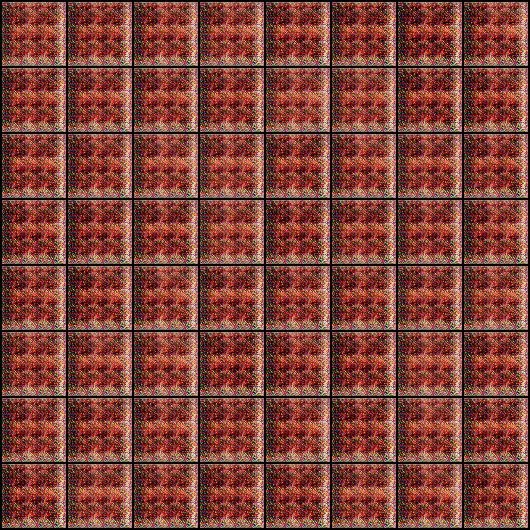

In [49]:
Image('./generated/generated-images-0001.png')

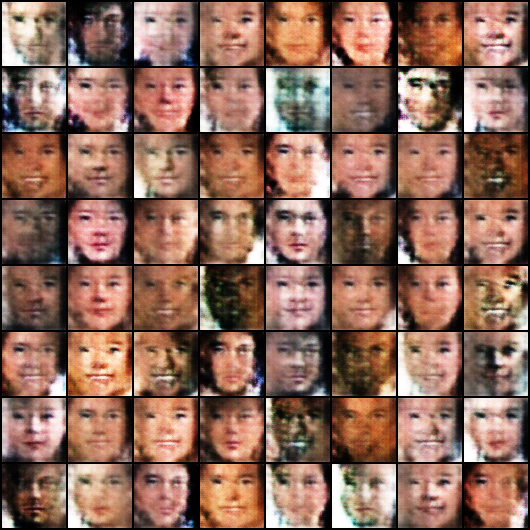

In [50]:
Image('./generated/generated-images-0005.png')

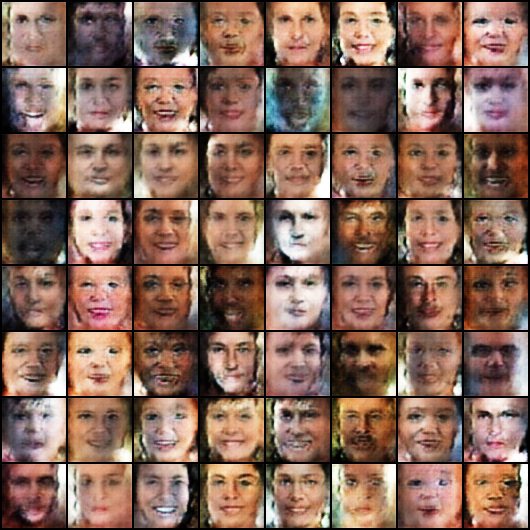

In [51]:
Image('./generated/generated-images-0010.png')

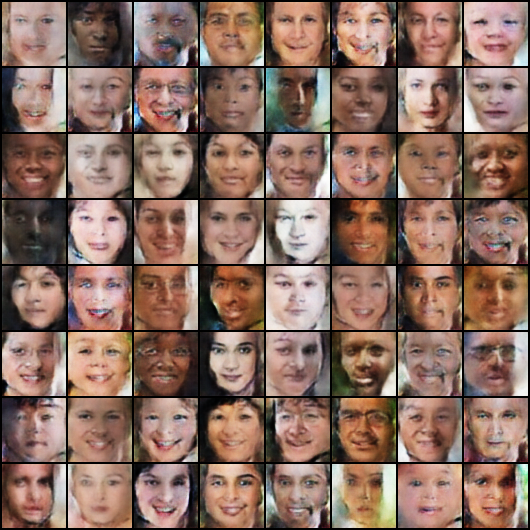

In [52]:
Image('./generated/generated-images-0020.png')

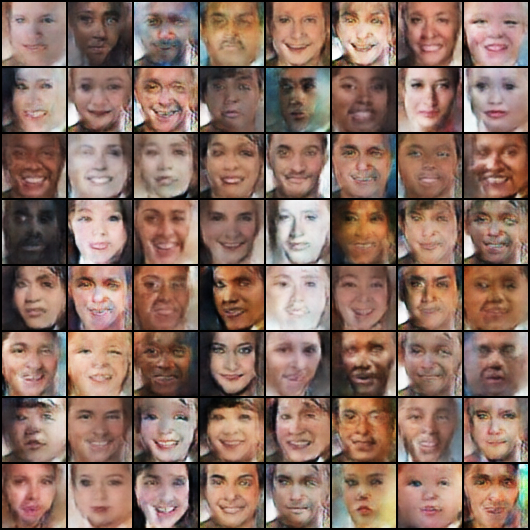

In [53]:
Image('./generated/generated-images-0025.png')

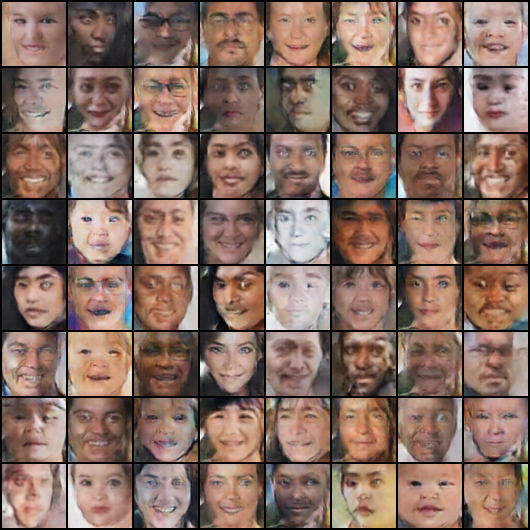

In [59]:
Image('./generated/generated-images-0050.png')

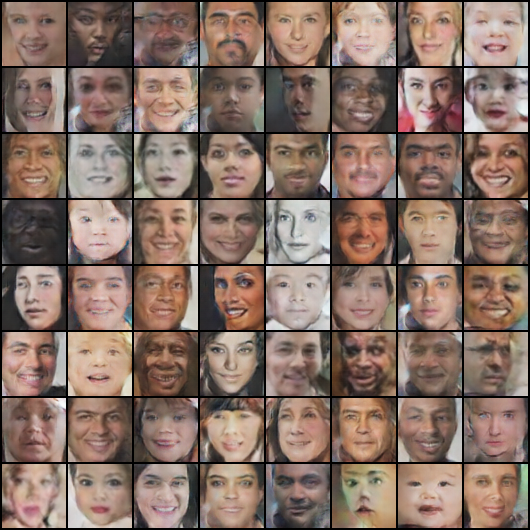

In [60]:
Image('./generated/generated-images-0075.png')

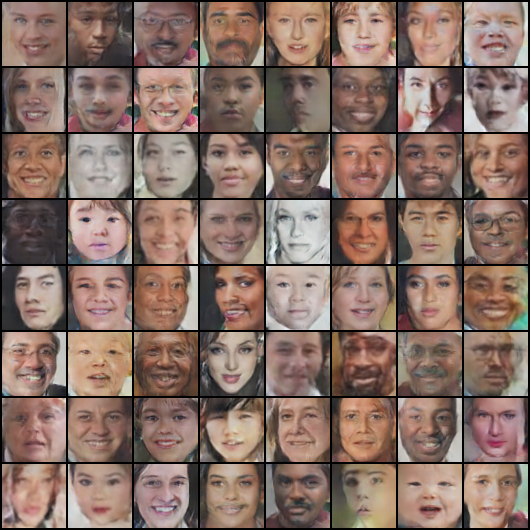

In [62]:
Image('./generated/generated-images-0099.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [54]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

You can watch the full animation here: http://youtube.com/watch?v=J4LY3Tq6OXw

We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

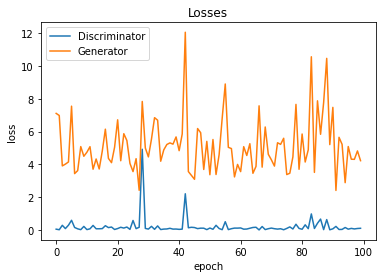

In [55]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

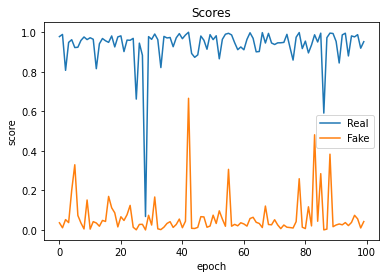

In [56]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');